# Type charts

By **Franklin Oliveira**

-----
This notebook contains all code necessary to make the "type" charts from `crustacea` database. Here you'll find some basic data treatment and charts' code. 

Database: <font color='blue'>'Planilha geral Atualizda FINAL com correções.xlsx'</font>.

In [1]:
import datetime
import numpy as np
import pandas as pd

from collections import defaultdict

# pacotes para visualização rápida
import seaborn as sns
import matplotlib.pyplot as plt

# Waffle Charts
from pywaffle import Waffle 
# docs: https://pywaffle.readthedocs.io/en/latest/examples/block_shape_distance_location_and_direction.html

# pacote para visualização principal
import altair as alt

# habilitando renderizador para notebook
alt.renderers.enable('notebook')

# desabilitando limite de linhas
alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

## Importing data...

In [2]:
excel = pd.ExcelFile('Planilha geral Atualizda FINAL com correções.xlsx')
sheet_name = excel.sheet_names

print('The excel file contains the following sheets:', sheet_name)
print('\nDatabase is in sheet:', sheet_name[0])

The excel file contains the following sheets: ['Banco de Dados Colecao Carcinol', 'Planilha1']

Database is in sheet: Banco de Dados Colecao Carcinol


In [3]:
# db = excel.parse(sheet_name[0], sep=';', encoding='utf-8-sig')
db = pd.read_csv('db.csv', sep=',', encoding='utf-8-sig', low_memory=False)  # db pre-treated by Asla
print(f'The database has {db.shape[0]} rows and {db.shape[1]} columns.')

The database has 28689 rows and 132 columns.


In [4]:
# copying database to another variable to make a few changes keeping the original intact
crustaceas = db.copy()

<br>

### Name columns

`Determiner First Name1` e `Determiner Last Name1`

#### treating determiner's name 

In this step, we're going to put together determiner's first and last name. 

`Determiner First Name1` + `Determiner Last Name1`

Just concatenating those two columns is not satisfactory because there's some dirt in these data columns. So, let's begin by treating them...

In [5]:
def treat_names(name, pos='first'):
    '''
    Treat names keeping NaN as such.
    
    Arguments: 
        - name: name to be treated. 
        - pos (str): name position. One of ['first', 'last']
    '''
    if type(name) == str and pos == 'first':     # primeiro nome
        
        if len(name.split(' ')) > 1:             # trata se o nome é composto (+ de um nome)
            return str(name).strip().split(' ')[0].capitalize()
        else:
            return str(name).strip().capitalize()
    
    elif type(name) == str and pos == 'last':    # último sobrenome
        
        if len(name.split(' ')) > 1:             # trata se o último nome é composto (+ de um sobrenome)
            return str(name).strip().split(' ')[-1].capitalize()
        else:
            return str(name).strip().capitalize()   
    else:
        return name

applying function to the two column names

In [6]:
crustaceas['Determiner First Name1'] = crustaceas['Determiner First Name1'].apply(treat_names)
# crustaceas['Determiner First Name1'].value_counts()

In [7]:
crustaceas['Determiner Last Name1'] = crustaceas['Determiner Last Name1'].apply(lambda x:
                                                                treat_names(x, pos='last'))
# crustaceas['Determiner Last Name1'].value_counts()

In [8]:
# creating column with First and Last name for identification
crustaceas['Determiner First_and_Last Name'] = crustaceas['Determiner First Name1'] + ' ' + crustaceas['Determiner Last Name1']

<br>

## Adjusting columns names

### removing '\n'

In [9]:
crustaceas.columns = [str(col).replace(r'\n','') for col in crustaceas.columns]

<br>

## preparing data for charts...

### Column: `Type Status1`

In [10]:
crustaceas['Type Status1'].value_counts().head()

Paratipo    433
Holotipo    203
ParaTIPO    142
PARATIPO    120
HOLOTIPO     82
Name: Type Status1, dtype: int64

#### Let's begin cleaning this data and lowering all cases.

In [11]:
crustaceas['Type Status1'] = crustaceas['Type Status1'].str.strip().str.lower().str.capitalize()

In [12]:
crustaceas['Type Status1'].value_counts().head()

Paratipo         695
Holotipo         285
Alotipo           81
Topotipo           9
Paralectotipo      6
Name: Type Status1, dtype: int64

### preparing taxonomy columns

`Kingdom` - `Phylum1` - `Subphylum1` - `Class1` - `Subclass1` - `Infraclass1` - `Superorder1` - `Order1` - `Suborder1` - `Infraorder1` - `Superfamily1` - `Family1` - `Subfamily1` - `Tribe1` - `Genus1` - `Species1`

In [13]:
taxon_columns = crustaceas.columns[21:37]  # selecionando colunas de taxonomia

# definindo função
def treat_str(x):
    return str(x).lower().capitalize().strip()

# aplicando tratamento
for col in taxon_columns:
    print(f'Adjusting column {col}')
    crustaceas[col] = crustaceas[col].apply(treat_str)

Adjusting column Kingdom
Adjusting column Phylum1
Adjusting column Subphylum1
Adjusting column Class1
Adjusting column Subclass1
Adjusting column Infraclass1
Adjusting column Superorder1
Adjusting column Order1
Adjusting column Suborder1
Adjusting column Infraorder1
Adjusting column Superfamily1
Adjusting column Family1
Adjusting column Subfamily1
Adjusting column Tribe1
Adjusting column Genus1
Adjusting column Species1


### adding `Genus1` and `Species1`together (they completely identify each animal's species)

In [14]:
crustaceas['genus_and_species'] = crustaceas['Genus1'] + ' ' + crustaceas['Species1']
crustaceas['genus_and_species'] = crustaceas['genus_and_species'].str.lower().str.capitalize()

<br>

### Collecting date (year) and sclicing main DB to a smaller dataset 

Columns: `Determined Date1` - `Class1` - `Kingdom` and more...

In [15]:
# slicing main database (crustaceas)
Table = crustaceas[['Cataloged Date','Determined Date1','Start Date','Class1','Kingdom', 
                    'Genus1', 'Species1', 'Type Status1',
                   'Determiner First_and_Last Name', 'Determiner First Name1',
                   'Determiner Last Name1', 'genus_and_species','Min Depth', 'Count 1',
                   'Species Author1', 'Order1', 'Suborder1', 'Infraorder1',
                   'Superfamily1', 'Family1', 'Subfamily1', 'Tribe1']].copy()

# OBS: Determined Date1 tem muitos valores faltantes... VERIFICAR ISSO
d = []
counter=0
for row in Table['Cataloged Date']:
    if not str(row).find('/')==-1:
        dates_values = str(row).split("/")
        year = int(dates_values[0])
        month = int(dates_values[1])
        if (month>1) and (month<12):
            #store the year and month in a datetime datatype for later sorting
            dateRecord = datetime.datetime(year,month,1)    
            
    d.append({'cataloged_year':year, 'count':Table.loc[counter,'Count 1'],
              'class':Table.loc[counter,'Class1'],
              'kingdom':Table.loc[counter,'Kingdom'], 'genus':Table.loc[counter,'Genus1'],
              'species':Table.loc[counter,'Species1'],
              'genus_and_species': Table.loc[counter,'genus_and_species'],
              'type_status':Table.loc[counter,'Type Status1'], 
              'determiner_first_and_last_name':Table.loc[counter,'Determiner First_and_Last Name'],
              'determiner_first_name':Table.loc[counter,'Determiner First Name1'],
              'determiner_last_name':Table.loc[counter,'Determiner Last Name1'],
              'depth':Table.loc[counter,'Min Depth'],
              'species_author':Table.loc[counter,'Species Author1'],
              'order':Table.loc[counter,'Order1'],
              'suborder':Table.loc[counter,'Suborder1'],
              'infraorder':Table.loc[counter, 'Infraorder1'],
              'superfamily':Table.loc[counter,'Superfamily1'],
              'family':Table.loc[counter,'Family1'],
              'subfamily':Table.loc[counter,'Subfamily1'],
              'tribe':Table.loc[counter,'Tribe1']
             })
    counter = counter+1

NewTable = pd.DataFrame(d)


### collecting determined year (p.s.: being careful to keep NaNs as they show up)
NewTable['determined_year'] = np.nan

d1 = []
counter=0
for row in Table['Determined Date1']:
    try:  # if Determined Date1 is empty, keep it so 
        if np.isnan(row):
            year= np.NAN
    
    except:
        if not str(row).find('/')==-1:
            dates_values = str(row).split("/")
            year = int(dates_values[0])
            month = int(dates_values[1])
            if (month>1) and (month<12):
                #store the year and month in a datetime datatype for later sorting
                dateRecord = datetime.datetime(year,month,1)    
    
    NewTable.loc[counter, 'determined_year'] = year
    counter = counter+1

    
### collecting start year (p.s.: being careful to keep NaNs as they show up)  
NewTable['start_year'] = np.nan
d1 = []
counter=0
for row in Table['Start Date']:
    try:  # if Start Date is empty, keep it so 
        if np.isnan(row):
            year= np.NAN
    
    except:
        if not str(row).find('/')==-1:
            dates_values = str(row).split("/")
            year = int(dates_values[0])
            month = int(dates_values[1])
            if (month>1) and (month<12):
                #store the year and month in a datetime datatype for later sorting
                dateRecord = datetime.datetime(year,month,1)    

    NewTable.loc[counter, 'start_year'] = year
    counter = counter+1

# NewTable['determined_year'] = pd.Series(year, index=NewTable.index)
NewTable.head(2)

,cataloged_year,count,class,kingdom,genus,species,genus_and_species,type_status,determiner_first_and_last_name,determiner_first_name,...,species_author,order,suborder,infraorder,superfamily,family,subfamily,tribe,determined_year,start_year
0,1980,5,Malacostraca,Animalia,Penaeus,Schmitti,Penaeus schmitti,NaN,Alceu Castro,Alceu,...,"Burkenroad, 1936",Decapoda,Nan,Nan,Nan,Penaeidae,Nan,Penaeini,NaN,1969.0
1,1980,15,Malacostraca,Animalia,Penaeus,Schmitti,Penaeus schmitti,NaN,Alceu Castro,Alceu,...,"Burkenroad, 1936",Decapoda,Nan,Nan,Nan,Penaeidae,Nan,Penaeini,NaN,NaN


In [16]:
# checks if NaNs are in the same position 
result = (NewTable['start_year'].isna() == crustaceas['Start Date'].isna()).sum() == NewTable.shape[0]

if result:
    print('Start year info is valid.')
else:
    print("There's something wrong with NewTable. Check how you're collecting Start Year info.")

Start year info is valid.


In [17]:
# year in which the holotipo was "firstly" found 
NewTable['holotipo_year'] = NewTable['species_author'].str.extract('(\d+)')

<br>

### creating `years` columns in crustaceas

In [18]:
def catch_year(row):
    if not str(row).find('/')==-1:
        dates_values = str(row).split("/")
        year = int(dates_values[0])
        month = int(dates_values[1])
        return year
    else:
        return np.NaN

In [19]:
crustaceas['determined_year'] = crustaceas['Determined Date1'].apply(catch_year)
crustaceas['start_year'] = crustaceas['Start Date'].apply(catch_year)
crustaceas['cataloged_year'] = crustaceas['Cataloged Date'].apply(catch_year)
crustaceas['holotipo_year'] = crustaceas['Species Author1'].str.extract('(\d+)')

<br>


## Graphs

---

### Types per species (filtered by order)

x: Species1, cor: Type Status1, size: counts

#### adjusting columns `determined_year`, `cataloged_year` and `start_year` to ```*int*``` format 

In [20]:
def str_with_nan2int(string):
    if not np.isnan(string):
        return int(string)
    else:
        return np.NAN

In [21]:
NewTable['determined_year'] = NewTable['determined_year'].apply(str_with_nan2int) #has NaN
# NewTable['determined_year'] = NewTable['determined_year'].astype(int)
NewTable['cataloged_year'] = NewTable['cataloged_year'].astype(int)
NewTable['start_year'] = NewTable['start_year'].apply(str_with_nan2int) #has NaN

<br>

### types per species

In [22]:
teste1 = NewTable[(~NewTable['order'].isna()) & (~NewTable['start_year'].isna())
                 & (~NewTable['type_status'].isna())]

orders = teste1['order'].unique()

In [23]:
for col in crustaceas.columns:
    if 'gen' in col.lower():
        print(col)

Genus1
Genus2
genus_and_species


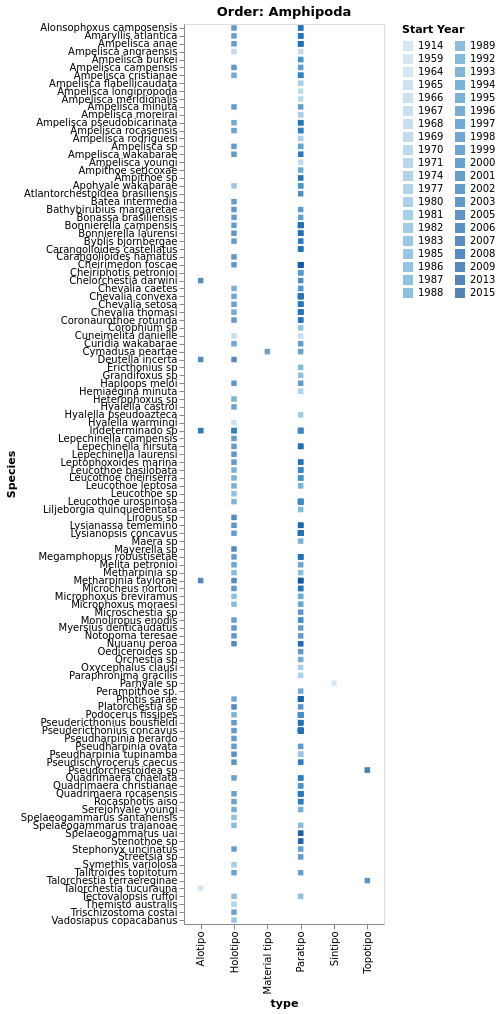

In [32]:
# mudanças: inverti X com Y e tirei o ordenamento das especies
g2 = alt.Chart(teste1[teste1['order'] == 'Amphipoda'], title='Order: Amphipoda', 
               width=200, height=900).mark_square().encode(
    x= alt.X('type_status', type='nominal', title='type'),
    y= alt.Y('genus_and_species', type='nominal', title='Species'),
#     sort= alt.EncodingSortField('start_year', op='max',order='descending')
    color= alt.Color('start_year', type='ordinal', legend=alt.Legend(title='Start Year',columns=2))
)

# salvando o gráfico
# g2.save('./viz/orders/determiner_and_species.svg')
# g2.save('./viz/orders/determiner_and_species.html')

g2

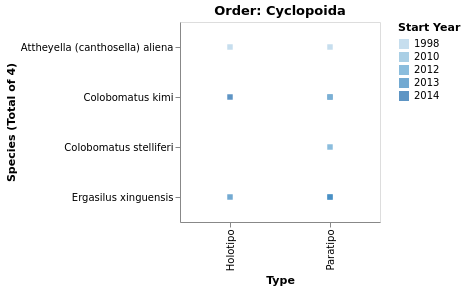

In [57]:
# creating graphs for all orders
for order in orders:
    # temporary dataframe (filtered by order)
    temp = teste1[teste1['order'] == order]
    
    # counts number of different species of that order
    num_species = len(temp['genus_and_species'].unique())
    
    g2 = alt.Chart(temp, title=f'Order: {order}',width=200, height= max(num_species*15,200)).mark_square().encode(
        x= alt.X('type_status', type='nominal', title='Type'),
        y= alt.Y('genus_and_species', type='nominal', title=f'Species (Total of {num_species})'),
#         sort= alt.EncodingSortField('determined_year', op='max',order='ascending')
        color= alt.Color('start_year', type='ordinal', legend=alt.Legend(title='Start Year',columns=1))
    )
    
    # saving graphs
#     g2.save(f'./types/per_species/{order}_per_types.svg')
#     g2.save(f'./types/per_species/{order}_per_types.png')
#     g2.save(f'./types/per_species/{order}_per_types.html')

g2

<br>

**The end!**

-----